In [1]:
import glam
import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt

In [2]:
import pymc3 as pm

In [3]:
np.random.seed(23) # from random.org

# 3.1. Hierarchical GLAM estimation and out of sample prediction

## Load data

In [4]:
# Load data
sufix = '_individual_Less_Inv_NoBin_Gamma-11_NUTS_33'
data = pd.read_csv('data/PF2019_data/GlamDataPF2019_Less_Inv_NoBin_33.csv')

# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

subject  trial  choice        rt  item_value_0  item_value_1    gaze_0  \
0        1      0       0  4261.735            63            42  0.603448   
1        1      1       1  3559.258           126           123  0.490772   
2        1      2       1  3754.464           123           129  0.490893   
3        1      3       0  2431.751           116           123  0.639125   
4        1      4       0  2199.342           131           123  0.702232   

     gaze_1  
0  0.396552  
1  0.509228  
2  0.509107  
3  0.360875  
4  0.297768

## Split data in training and test sets

In [5]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

test_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_test'+sufix+'.csv'))
train_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (1920 trials) and test (1920 trials) sets...


In [6]:
train_data

subject  trial  choice        rt  item_value_0  item_value_1    gaze_0  \
0          1      0       0  4261.735            63            42  0.603448   
2          1      2       1  3754.464           123           129  0.490893   
4          1      4       0  2199.342           131           123  0.702232   
6          1      6       0  6606.698            95            93  0.602831   
8          1      8       1  5213.480           123           125  0.475195   
10         1     10       0  2007.957           127           123  0.638397   
12         1     12       0  1978.076           123           117  0.605235   
14         1     14       1  3907.246            63            49  0.479771   
16         1     16       0  1823.377           109            93  0.629489   
18         1     18       0  4920.474            72            63  0.694959   
20         1     20       0  1705.811           123           131  0.636436   
22         1     22       0  2474.714            96            93  0.642971   
24         1     24       0  3790.480           129           123  0.565495   
26         1     26       1  3822.251           123           127  0.468667   
28         1     28       1  2252.245            40            63  0.519646   
30         1     30       1  4155.502            47            63  0.670523   
32         1     32       0  5814.551            63            47  0.763474   
34         1     34       0  1743.991            93            96  0.657066   
36         1     36       1  3381.750            93           109  0.627425   
38         1     38       1  3602.313            49            63  0.470957   
40         1     40       1  7964.301            45            63  0.539804   
42         1     42       0  2122.334           119           123  0.699431   
44         1     44       0  2201.475            68            63  0.585813   
46         1     46       0  2017.429            77            93  0.671605   
48         1     48       0  2528.386            63            45  0.717070   
50         1     50       0  1513.221            63            54  0.638326   
52         1     52       0  3815.203           115           123  0.563237   
54         1     54       0  3013.624            99            93  0.474341   
56         1     56       0  1818.684           107            93  0.665297   
58         1     58       0  3156.807            79            63  0.764561   
..       ...    ...     ...       ...           ...           ...       ...   
60        33     60       0  5574.181            98            93  0.473662   
62        33     62       0  1623.716            84            63  0.581980   
64        33     64       1  5266.289            63            75  0.485209   
66        33     66       1  4480.192            63            79  0.480105   
68        33     68       1  2559.781           123           119  0.416775   
70        33     70       1  4939.104           123           121  0.480362   
72        33     72       0  3524.365            86            63  0.515382   
74        33     74       0  4286.780            93            77  0.495837   
76        33     76       0  4953.792           123           118  0.505023   
78        33     78       0  1525.091           128           123  0.535368   
80        33     80       1  5318.646           123           120  0.571120   
82        33     82       0  1867.922            93            85  0.612229   
84        33     84       0  4005.469            70            63  0.416217   
86        33     86       0  4756.104            93           101  0.413177   
88        33     88       0  2002.718            93            83  0.633215   
90        33     90       1  2154.276            93           103  0.499230   
92        33     92       1  3600.589            91            93  0.500618   
94        33     94       0  3099.150            77            63  0.469571   
96        33     96       1  4201.412           113    

## Hierarchical GLAM estimation

### 1. full GLAM

In [7]:
# Fitting full GLAM
print('Fitting full GLAM individually...')

glam_full = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_PF2019_full'+sufix+'.npy')):
    glam_full.make_model('individual', gamma_bounds=(-1, 1), t0_val=0)
    glam_full.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_PF2019_full'+sufix+'.npy'))   

Fitting full GLAM individually...
  Found old parameter estimates in "results/estimates". Skipping estimation...


In [8]:
# Save parameter estimates
np.save(str('results/estimates/glam_PF2019_full'+sufix+'.npy'), glam_full.estimates)
pd.DataFrame(glam_full.estimates)

0
0   {'b': 1.0, 'p_error': 0.05, 'v': 3.6e-05, 'gam...
1   {'b': 1.0, 'p_error': 0.05, 'v': 1.4e-05, 'gam...
2   {'b': 1.0, 'p_error': 0.05, 'v': 3.6e-05, 'gam...
3   {'b': 1.0, 'p_error': 0.05, 'v': 2.1e-05, 'gam...
4   {'b': 1.0, 'p_error': 0.05, 'v': 3.1e-05, 'gam...
5   {'b': 1.0, 'p_error': 0.05, 'v': 5.5e-05, 'gam...
6   {'b': 1.0, 'p_error': 0.05, 'v': 2.9e-05, 'gam...
7   {'b': 1.0, 'p_error': 0.05, 'v': 5.3e-05, 'gam...
8   {'b': 1.0, 'p_error': 0.05, 'v': 0.000107, 'ga...
9   {'b': 1.0, 'p_error': 0.05, 'v': 4.5e-05, 'gam...
10  {'b': 1.0, 'p_error': 0.05, 'v': 2.4e-05, 'gam...
11  {'b': 1.0, 'p_error': 0.05, 'v': 5.7e-05, 'gam...
12  {'b': 1.0, 'p_error': 0.05, 'v': 2e-05, 'gamma...
13  {'b': 1.0, 'p_error': 0.05, 'v': 4e-05, 'gamma...
14  {'b': 1.0, 'p_error': 0.05, 'v': 4.5e-05, 'gam...
15  {'b': 1.0, 'p_error': 0.05, 'v': 4.1e-05, 'gam...
16  {'b': 1.0, 'p_error': 0.05, 'v': 1.7e-05, 'gam...
17  {'b': 1.0, 'p_error': 0.05, 'v': 2.1e-05, 'gam...
18  {'b': 1.0, 'p_error': 0.05, 'v': 3.1e-05, 'gam...
19  {'b': 1.0, 'p_error': 0.05, 'v': 3.9e-05, 'gam...
20  {'b': 1.0, 'p_error': 0.05, 'v': 3.1e-05, 'gam...
21  {'b': 1.0, 'p_error': 0.05, 'v': 3.3e-05, 'gam...
22  {'b': 1.0, 'p_error': 0.05, 'v': 2.9e-05, 'gam...
23  {'b': 1.0, 'p_error': 0.05, 'v': 2.8e-05, 'gam...
24  {'b': 1.0, 'p_error': 0.05, 'v': 1.6e-05, 'gam...
25  {'b': 1.0, 'p_error': 0.05, 'v': 4e-05, 'gamma...
26  {'b': 1.0, 'p_error': 0.05, 'v': 2.8e-05, 'gam...
27  {'b': 1.0, 'p_error': 0.05, 'v': 5.1e-05, 'gam...
28  {'b': 1.0, 'p_error': 0.05, 'v': 7.2e-05, 'gam...
29  {'b': 1.0, 'p_error': 0.05, 'v': 5.6e-05, 'gam...
30  {'b': 1.0, 'p_error': 0.05, 'v': 3.9e-05, 'gam...
31  {'b': 1.0, 'p_error': 0.05, 'v': 3.2e-05, 'gam...

In [21]:
# Compute WAICs
print('Computing WAIC scores for full model...')
if not os.path.exists(str('results/waic/glam_PF2019_full'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_full.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_full.waic = np.load(str('results/waic/glam_PF2019_full'+ sufix +'.npy'))

# Compute WAICs
np.save(str('results/waic/glam_PF2019_full'+ sufix +'.npy'), glam_full.waic)

Computing WAIC scores for full model...
  Found old DIC scores in "results/waic". Skipping WAIC computation...


In [22]:
glam_full.waic

array([[1.06067528e+03, 0.00000000e+00, 3.44525824e+00, 1.00000000e+00],
       [1.18596451e+03, 0.00000000e+00, 1.55984881e+00, 1.00000000e+00],
       [1.02859043e+03, 0.00000000e+00, 5.96888506e+00, 1.00000000e+00],
       [1.21235747e+03, 0.00000000e+00, 2.37448071e+00, 1.00000000e+00],
       [1.11349483e+03, 0.00000000e+00, 2.41405025e+00, 1.00000000e+00],
       [9.90927749e+02, 0.00000000e+00, 2.40782996e+00, 1.00000000e+00],
       [1.14186637e+03, 0.00000000e+00, 3.98993289e+00, 1.00000000e+00],
       [1.02415021e+03, 0.00000000e+00, 2.54501800e+00, 1.00000000e+00],
       [9.64604104e+02, 0.00000000e+00, 1.40961764e+00, 1.00000000e+00],
       [1.04177134e+03, 0.00000000e+00, 4.17432891e+00, 1.00000000e+00],
       [1.12302707e+03, 0.00000000e+00, 1.99923953e+00, 1.00000000e+00],
       [9.88390599e+02, 0.00000000e+00, 3.03109604e+00, 1.00000000e+00],
       [1.06564541e+03, 0.00000000e+00, 2.59330438e+00, 1.00000000e+00],
       [1.07560990e+03, 0.00000000e+00, 1.41829206e

In [23]:
# Compute LOO

glam_full.loo = pm.loo(trace=glam_full.trace, model=glam_full.model)
glam_full.loo
np.save(str('results/loo/glam_PF2019_full'+ sufix +'.npy'), glam_full.loo)

AttributeError: 'GLAM' object has no attribute 'trace'

In [24]:
glam_full.loo

AttributeError: 'GLAM' object has no attribute 'loo'

In [9]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_PF2019_full'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_PF2019_full'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_PF2019_full'+sufix+'.csv'))

glam_full.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (1920 trials) with new data (1920 trials)...
  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...


subject  trial  repeat  choice      rt  item_value_0    gaze_0  \
0      1.0    0.0     0.0     1.0  3826.0           126  0.490772   
1      1.0    0.0     1.0     0.0  2485.0           126  0.490772   
2      1.0    0.0     2.0     0.0  7978.0           126  0.490772   
3      1.0    0.0     3.0     1.0  3229.0           126  0.490772   
4      1.0    0.0     4.0     0.0  4554.0           126  0.490772   

   item_value_1    gaze_1  
0           123  0.509228  
1           123  0.509228  
2           123  0.509228  
3           123  0.509228  
4           123  0.509228

### 1. no-bias GLAM

In [ ]:
# Fitting no-bias GLAM
print('Fitting no-bias GLAM hierarchically...')

glam_nobias = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_PF2019_nobias'+sufix+'.npy')):
    glam_nobias.make_model('hierarchical', gamma_val=1.0, t0_val=0)
    glam_nobias.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_nobias.estimates = np.load(str('results/estimates/glam_PF2019_nobias'+sufix+'.npy'))
 

In [ ]:
   
# Save parameter estimates
np.save(str('results/estimates/glam_PF2019_nobias'+sufix+'.npy'), glam_nobias.estimates)
pd.DataFrame(glam_nobias.estimates)

In [ ]:
# In case it is already fitted
params_part_like = pd.DataFrame.from_dict(glam_nobias.estimates.item(0))
params_part_like

In [ ]:
# Compute LOO

glam_nobias.loo = pm.loo(trace=glam_nobias.trace, model=glam_nobias.model)
glam_nobias.loo

np.save(str('results/loo/glam_PF2019_nobias'+ sufix +'.npy'), glam_nobias.loo
)

In [ ]:
# Predictions
print('Predicting test set data using no-bias GLAM...')
glam_nobias.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_PF2019_nobias'+sufix+'.csv')):
    glam_nobias.predict(n_repeats=50)
    glam_nobias.prediction.to_csv(str('results/predictions/glam_PF2019_nobias'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical no-bias GLAM predictions in "results/predictions". Skipping prediction...')
    glam_nobias.prediction = pd.read_csv(str('results/predictions/glam_PF2019_nobias'+sufix+'.csv'))

glam_nobias.prediction.head()

## 2. Plot fit

Close Figure to continue...


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


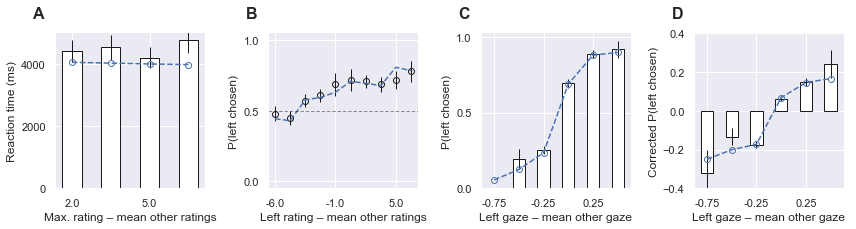

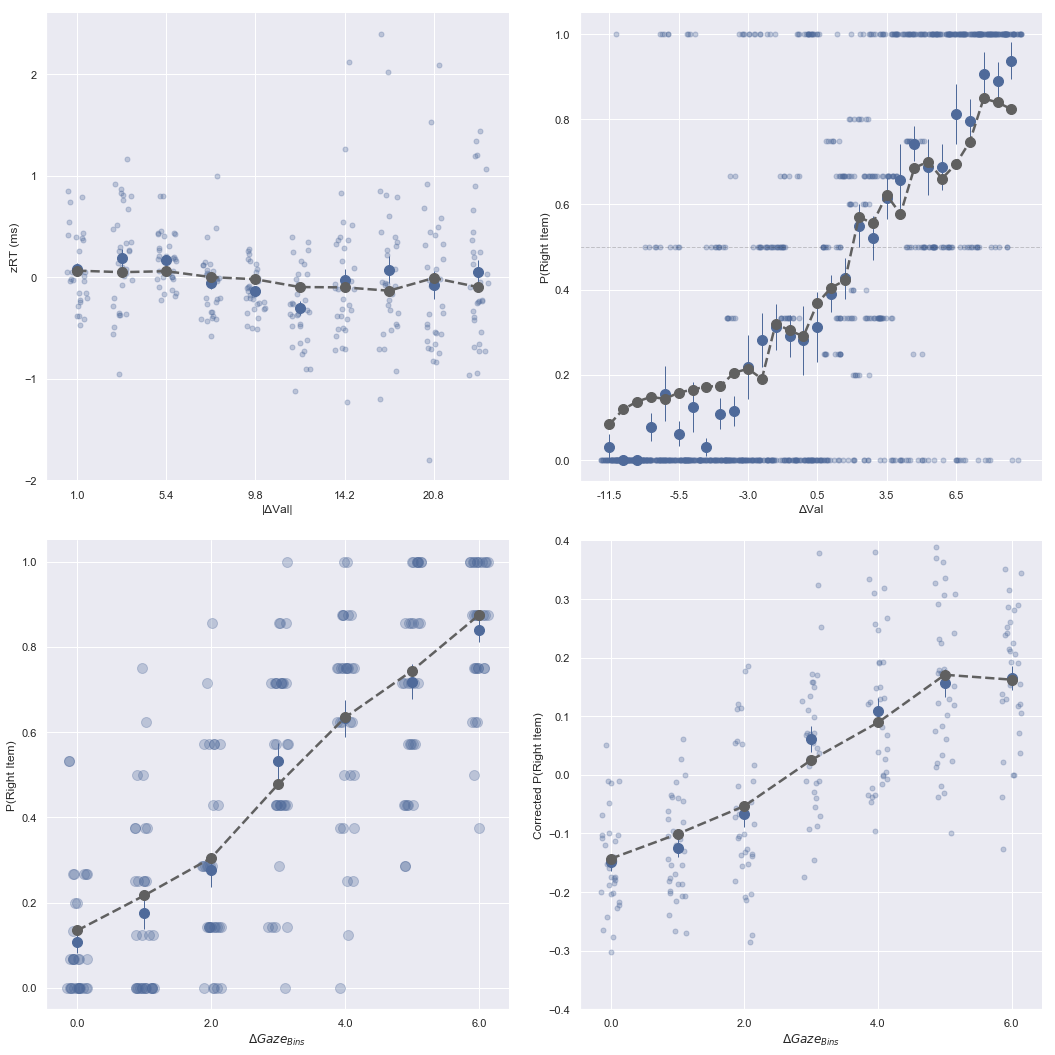

In [10]:
print('Close Figure to continue...')
glam.plot_fit(test_data, [glam_full.prediction]);
glam.plots_pretty.plot_fit(test_data, [glam_full.prediction]);

#glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);

plt.show()

## Parameters for full hierarchical model

In [24]:
params_participant = glam_full.estimates
params_participant

[{'b': 1.0,
  'p_error': 0.05,
  'v': 5.1e-05,
  'gamma': -0.77,
  'SNR': 125.41,
  's': 0.0081,
  'tau': 0.01,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 1.6e-05,
  'gamma': -0.99,
  'SNR': 290.78,
  's': 0.006238,
  'tau': 0.05,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 3.5e-05,
  'gamma': -0.11,
  'SNR': 230.96,
  's': 0.008048,
  'tau': 0.11,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 2.1e-05,
  'gamma': -0.99,
  'SNR': 434.59,
  's': 0.009583,
  'tau': 0.1,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 3.2e-05,
  'gamma': -0.99,
  'SNR': 165.04,
  's': 0.005638,
  'tau': 0.06,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 5.7e-05,
  'gamma': -0.71,
  'SNR': 83.7,
  's': 0.005543,
  'tau': 0.09,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 3e-05,
  'gamma': -0.99,
  'SNR': 232.79,
  's': 0.008216,
  'tau': 0.08,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 5.1e-05,
  'gamma

In [21]:
params_participant = pd.DataFrame.from_dict(glam_full.estimates.item(0))

AttributeError: 'list' object has no attribute 'item'

In [ ]:
params_participant

In [ ]:
print ("Mean gamma " +  str(params_participant['gamma'].mean()))

In [ ]:
hist = params_participant[['SNR','gamma','tau','v']].hist(figsize = [20,3] , layout=[1,4],bins = 20)

## [END] 